# Redes Neurais Artificiais - Identificação de Websites de *Phishing*
Atividade Avaliativa 3 - *Hands-On*

#### Problema:
- Identificação de Websites *Phishing* por uso de Redes Neurais Artificiais e AutoML

#### Dataset:
- "[*Website Phishing*](https://archive.ics.uci.edu/dataset/379/website+phishing)" por Neda Abdelhamid

#### Equipe:
- Daniele Simas Guimaraes - 2015310060
- Felipe Muniz Amorim - 2115080033
- Jose Manuel Coelho Dos Santos - 2115080052

## Importação de bibliotecas

In [85]:
import pickle

import arff
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics

import matplotlib.pyplot as plt

## Carregando os dados

Classes dos atributos:

| Legítimo | Suspeito | Phishing |
|  ------  |  ------  |  ------  |
|    1     |     0    |    -1    |

In [86]:
dataset = None

with open('data/PhishingData.arff', 'r') as file:
    data = arff.load(file)

    dataset = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

dataset

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


In [87]:
print('# Tipos das colunas:')
print(dataset.dtypes, end='\n\n')

print("# Após conversão:")
dataset = dataset.astype(int)
print(dataset.dtypes)

# Tipos das colunas:
SFH                  object
popUpWidnow          object
SSLfinal_State       object
Request_URL          object
URL_of_Anchor        object
web_traffic          object
URL_Length           object
age_of_domain        object
having_IP_Address    object
Result               object
dtype: object

# Após conversão:
SFH                  int64
popUpWidnow          int64
SSLfinal_State       int64
Request_URL          int64
URL_of_Anchor        int64
web_traffic          int64
URL_Length           int64
age_of_domain        int64
having_IP_Address    int64
Result               int64
dtype: object


In [88]:
dataset['having_IP_Address'] = dataset['having_IP_Address'].replace(0, -1)
dataset.rename(columns={'popUpWidnow': 'popUp_Window'}, inplace=True)
dataset

,SFH,popUp_Window,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,-1,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,-1,1
3,1,0,1,-1,-1,0,1,1,-1,0
4,-1,-1,1,-1,0,0,-1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,-1,1
1349,-1,0,1,0,-1,0,0,1,-1,-1
1350,-1,0,-1,-1,-1,0,-1,-1,-1,1
1351,0,0,1,0,0,0,-1,1,-1,1


## Validação Cruzada - K-Fold

In [89]:
def linear_scores(test, pred):
    # Calcular as métricas de avaliação
    mse = metrics.mean_squared_error(test, pred)
    r2 = metrics.r2_score(test, pred)
    return {
        "mse": mse,
        "r2": r2,
    }
    
def log_scores(test, pred):
    # Calcular as métricas de avaliação
    precision = metrics.precision_score(test, pred, average="weighted")
    accuracy = metrics.accuracy_score(test, pred)
    recall = metrics.recall_score(test, pred, average="weighted")
    f1 = metrics.f1_score(test, pred, average="weighted")
    return {
        "precision": precision,
        "accuracy": accuracy,
        "recall": recall,
        "f1": f1,
    }

In [90]:
# Atributo alvo
y = dataset["Result"]

# Atributos preditores
X = dataset.copy()
X.drop("Result", axis=1, inplace=True)

In [91]:
X.head()

,SFH,popUp_Window,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
0,1,-1,1,-1,-1,1,1,1,-1
1,-1,-1,-1,-1,-1,0,1,1,1
2,1,-1,0,0,-1,0,-1,1,-1
3,1,0,1,-1,-1,0,1,1,-1
4,-1,-1,1,-1,0,0,-1,1,-1


In [92]:
y.head()

0    0
1    1
2    1
3    0
4    1
Name: Result, dtype: int64

In [93]:
def training_linear(k):
    kf = KFold(n_splits=k, shuffle=True)
    model = LinearRegression()

    scores_per_iteration = []
    for train_index, test_index in kf.split(X):
        # Dividir os dados em conjuntos de treino e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treinar o modelo
        model.fit(X_train, y_train)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        
        # Avaliar a acurácia
        scores_per_iteration.append(linear_scores(y_test, y_pred))
    
    # Calcular o máximo, média e variância padrão para cada chave
    r2s = [score['r2'] for score in scores_per_iteration]
    mses = [score['mse'] for score in scores_per_iteration]
    print(f"Melhor Coeficiente de Determinação (R²): {np.max(r2s):.2f}", f"Valor médio: {np.mean(r2s):.2f} ± {np.std(r2s, ddof=1):.2f}", sep='\n')
    print()
    print(f"Melhor Erro Quadrático Médio (MSE): {np.min(mses):.2f}", f"Valor médio: {np.mean(mses):.2f} ± {np.std(mses, ddof=1):.2f}", sep='\n')


    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(f"K-Folds com K = {k}")
    
    ax[0].scatter(range(len(scores_per_iteration)), [score['mse'] for score in scores_per_iteration])
    ax[0].set_title('Erro Quadrático Médio (MSE)')
    ax[0].set_xlabel('Iteração')
    ax[0].set_ylabel('MSE')

    ax[1].scatter(range(len(scores_per_iteration)), [score['r2'] for score in scores_per_iteration])
    ax[1].set_title('Coeficiente de determinação (R²)')
    ax[1].set_xlabel('Iteração')
    ax[1].set_ylabel('R²')



    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plots
    plt.show()
    

Melhor Coeficiente de Determinação (R²): 0.68
Valor médio: 0.62 ± 0.04

Melhor Erro Quadrático Médio (MSE): 0.30
Valor médio: 0.34 ± 0.03


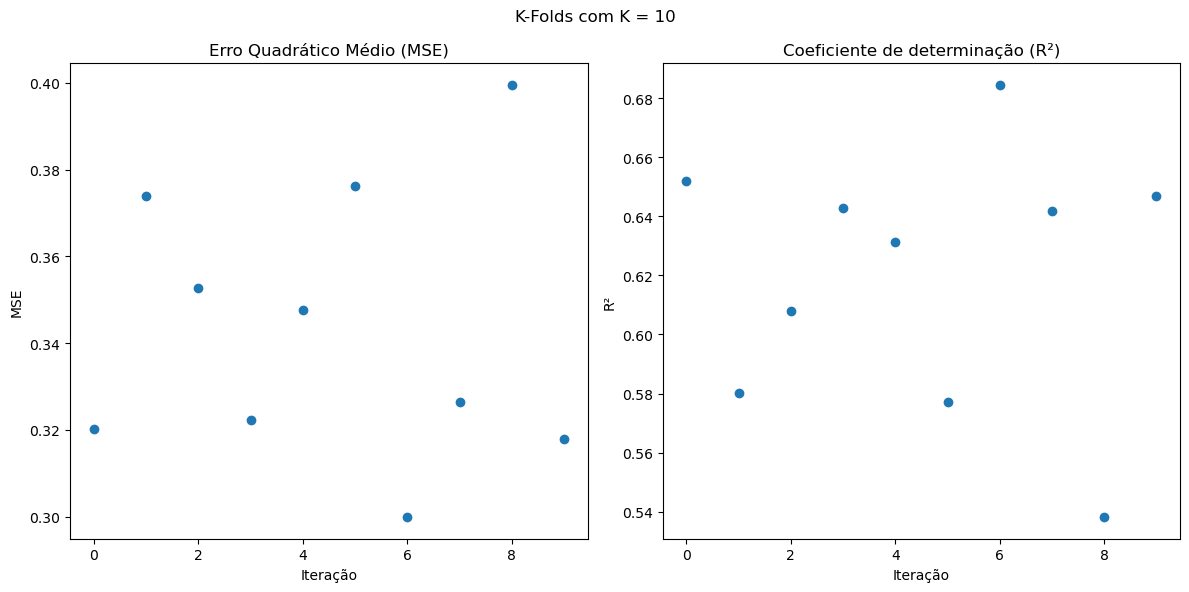

In [94]:
# K = 10
training_linear(10)

Melhor Coeficiente de Determinação (R²): 0.72
Valor médio: 0.62 ± 0.06

Melhor Erro Quadrático Médio (MSE): 0.26
Valor médio: 0.34 ± 0.05


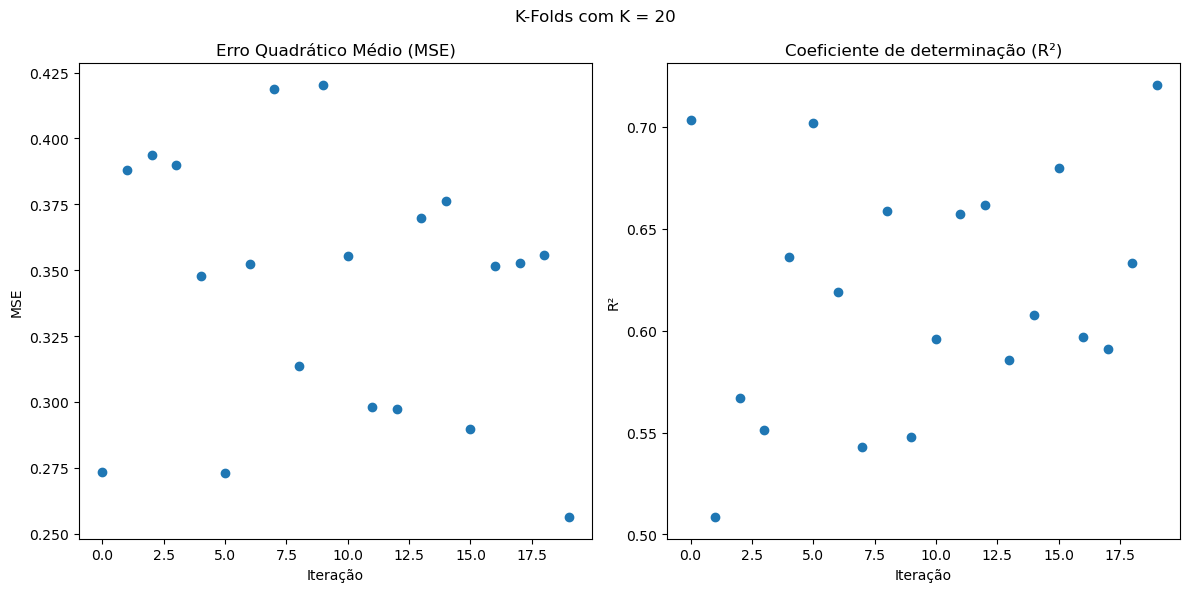

In [95]:
# K = 10
training_linear(20)

Melhor Coeficiente de Determinação (R²): 0.86
Valor médio: 0.61 ± 0.12

Melhor Erro Quadrático Médio (MSE): 0.13
Valor médio: 0.34 ± 0.10


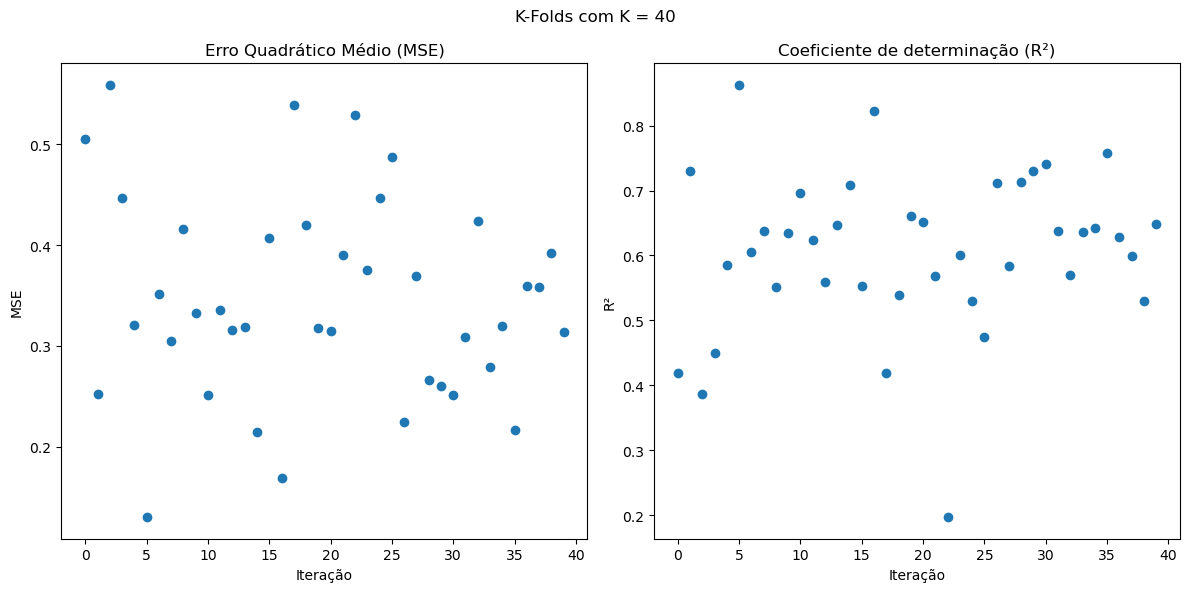

In [96]:
# K = 10
training_linear(40)

In [102]:
def training_logistic(k):
    kf = KFold(n_splits=k, shuffle=True)
    model = LogisticRegression()

    scores_per_iteration = []
    for train_index, test_index in kf.split(X):
        # Dividir os dados em conjuntos de treino e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Treinar o modelo
        model.fit(X_train, y_train)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        
        # Avaliar a acurácia
        scores_per_iteration.append(log_scores(y_test, y_pred))


    # Calcular o máximo, média e variância padrão para cada chave
    acc = [score['accuracy'] for score in scores_per_iteration]
    prec = [score['precision'] for score in scores_per_iteration]
    rec = [score['recall'] for score in scores_per_iteration]
    f1 = [score['f1'] for score in scores_per_iteration]

    print(f"Melhor Acurácia: {np.max(acc):.2f}", f"Valor médio: {np.mean(acc):.2f} ± {np.std(acc, ddof=1):.2f}", sep='\n')
    print()
    print(f"Melhor Precisão: {np.max(prec):.2f}", f"Valor médio: {np.mean(prec):.2f} ± {np.std(prec, ddof=1):.2f}", sep='\n')
    print()
    print(f"Melhor Revocação: {np.max(rec):.2f}", f"Valor médio: {np.mean(rec):.2f} ± {np.std(rec, ddof=1):.2f}", sep='\n')
    print()
    print(f"Melhor F1-Score: {np.max(f1):.2f}", f"Valor médio: {np.mean(f1):.2f} ± {np.std(f1, ddof=1):.2f}", sep='\n')


    fig, ax = plt.subplots(2, 2, figsize=(12, 6))

    fig.suptitle(f"K-Folds com K = {k}")
    
    ax[0][0].scatter(range(len(scores_per_iteration)), [score['accuracy'] for score in scores_per_iteration])
    ax[0][0].set_title('Acurácia')
    ax[0][0].set_xlabel('Iteração')

    ax[0][1].scatter(range(len(scores_per_iteration)), [score['precision'] for score in scores_per_iteration])
    ax[0][1].set_title('Precisão')
    ax[0][1].set_xlabel('Iteração')

    ax[1][0].scatter(range(len(scores_per_iteration)), [score['recall'] for score in scores_per_iteration])
    ax[1][0].set_title('Revocação')
    ax[1][0].set_xlabel('Iteração')

    ax[1][1].scatter(range(len(scores_per_iteration)), [score['f1'] for score in scores_per_iteration])
    ax[1][1].set_title('F1-Score')
    ax[1][1].set_xlabel('Iteração')



    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plots
    plt.show()
    

Melhor Acurácia: 0.88
Valor médio: 0.83 ± 0.03

Melhor Precisão: 0.87
Valor médio: 0.80 ± 0.04

Melhor Revocação: 0.88
Valor médio: 0.83 ± 0.03

Melhor F1-Score: 0.87
Valor médio: 0.81 ± 0.03


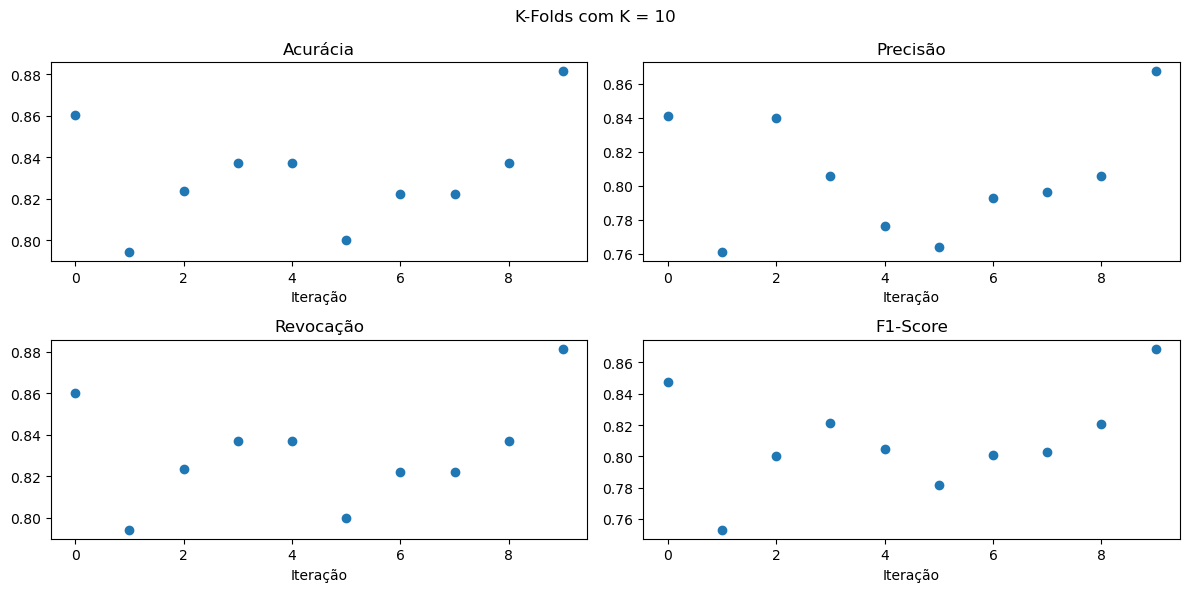

In [103]:
training_logistic(10)

/home/fmabr/miniconda3/envs/phish/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fmabr/miniconda3/envs/phish/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fmabr/miniconda3/envs/phish/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fmabr/miniconda3/envs/phish/lib

Melhor Acurácia: 0.94
Valor médio: 0.83 ± 0.04

Melhor Precisão: 0.94
Valor médio: 0.80 ± 0.06

Melhor Revocação: 0.94
Valor médio: 0.83 ± 0.04

Melhor F1-Score: 0.93
Valor médio: 0.81 ± 0.05


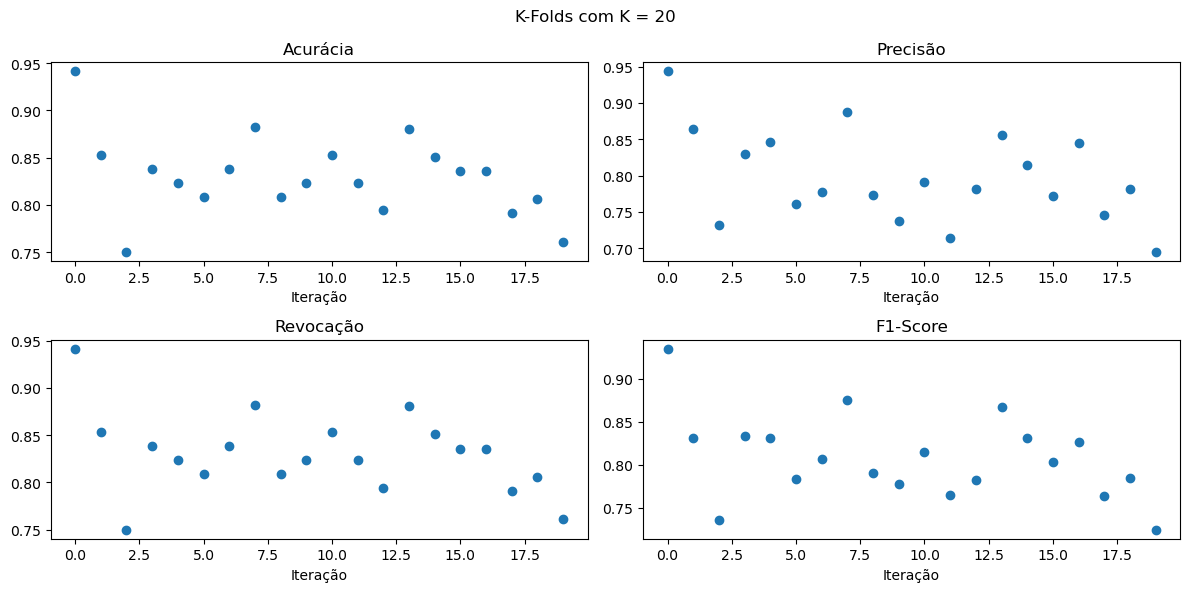

In [105]:
training_logistic(20)

/home/fmabr/miniconda3/envs/phish/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fmabr/miniconda3/envs/phish/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fmabr/miniconda3/envs/phish/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fmabr/miniconda3/envs/phish/lib

Melhor Acurácia: 0.94
Valor médio: 0.83 ± 0.06

Melhor Precisão: 0.94
Valor médio: 0.80 ± 0.09

Melhor Revocação: 0.94
Valor médio: 0.83 ± 0.06

Melhor F1-Score: 0.94
Valor médio: 0.81 ± 0.07


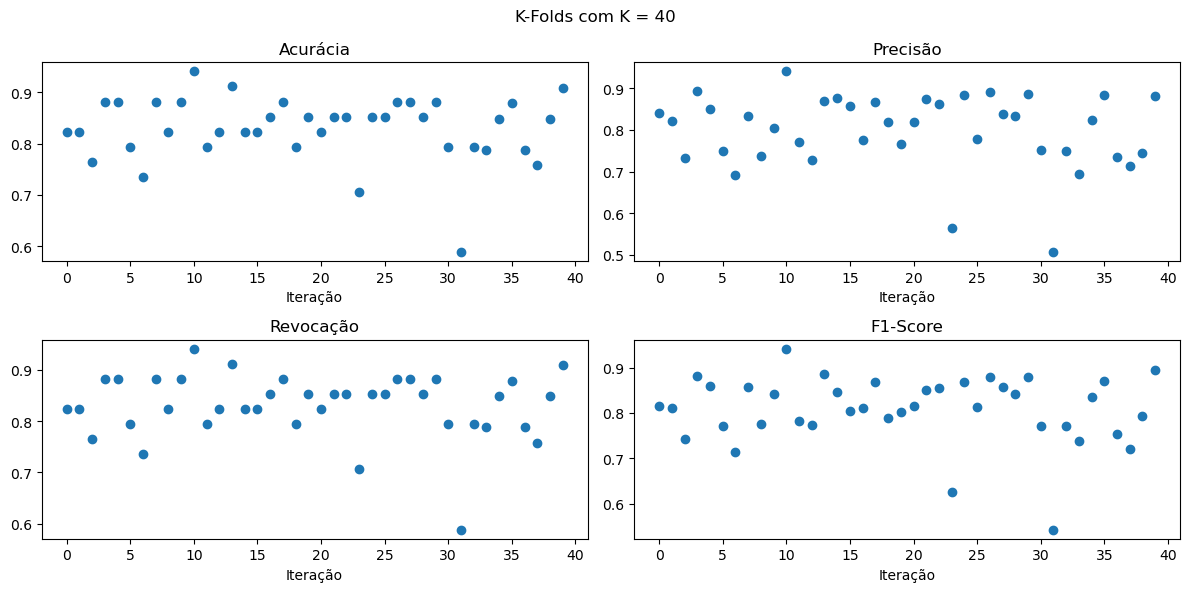

In [104]:
training_logistic(40)